In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV, LeaveOneOut, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score,balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.metrics import f1_score



In [4]:
df = pd.read_csv('processedData.csv', index_col=[0])
df

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,marital_divorced,marital_married,marital_single
0,5,261,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
1,5,149,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
2,3,226,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
3,3,151,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
4,5,307,1,3,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,5,334,1,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0
41184,4,383,1,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0
41185,5,189,2,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0
41186,4,442,1,3,0,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,0,0,1,0,0,0,1,0


In [5]:
def converty(x):
    if x=='yes':
        return 1
    return 0

y = df['y']
y = y.apply(converty)
X = df.drop(columns=['y'])

### Splitting data into training and test dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17)


### SMOTE oversampled data

In [7]:
# Create an oversampled training data
smote = SMOTE(random_state = 17)
X_SMOTE, y_SMOTE = smote.fit_resample(X_train, y_train)

### Standard Scaled Data

In [76]:
standardizer = StandardScaler()

### Classification Report plot function

In [8]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.summer):
    title = title or 'Classification report'
    lines = cr.split('\n')
    classes = []
    matrix = []

    for line in lines[2:(len(lines)-4)]:
        s = line.split()
        classes.append(s[0])
        value = [float(x) for x in s[1: len(s) - 1]]
        matrix.append(value)

    fig, ax = plt.subplots(1)

    for column in range(len(matrix)+1):
        for row in range(len(classes)):
            txt = matrix[row][column]
            ax.text(column,row,matrix[row][column],va='center',ha='center')

    fig = plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(len(classes)+1)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    plt.show()

### ROC Curve Plot function

In [9]:
def ROC_function(model,X_test,y_test):
    noskill_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    prob = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    prob = prob[:, 1]
    # calculate scores
    noskill_auc = roc_auc_score(y_test, noskill_probs)
    auc = roc_auc_score(y_test, prob)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (noskill_auc))
    print('RF: ROC AUC=%.3f' % (auc))
    # calculate roc curves
    noskill_fpr, noskill_tpr, _ = roc_curve(y_test, noskill_probs)
    fpr, tpr, _ = roc_curve(y_test, prob)
    # plot the roc curve for the model
    plt.figure(figsize=(16,8))
    plt.plot(noskill_fpr, noskill_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='RF')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

***

## KNN 

### KNN on imbalanced data


* #### Without Standard Scaling of data

In [10]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.9026108075288403

In [11]:
y_pred = knn.predict(X_test)

In [12]:
knn_acc = round(metrics.accuracy_score(y_test, y_pred)*100, 2)
knn_bacc = round(metrics.balanced_accuracy_score(y_test, y_pred)*100, 2)

print(f"Accuracy: {knn_acc}%")
print(f"Balanced Accuracy: {knn_bacc}%")


Accuracy: 90.26%
Balanced Accuracy: 71.3%


In [13]:
knn_classification_report = classification_report(y_test, y_pred)
print(knn_classification_report)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7303
           1       0.59      0.47      0.52       932

    accuracy                           0.90      8235
   macro avg       0.76      0.71      0.73      8235
weighted avg       0.89      0.90      0.90      8235



In [14]:
knn_cm = confusion_matrix(y_test, y_pred)
print(knn_cm)

[[6997  306]
 [ 496  436]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

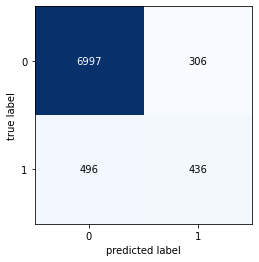

In [15]:
plot_confusion_matrix(knn_cm)

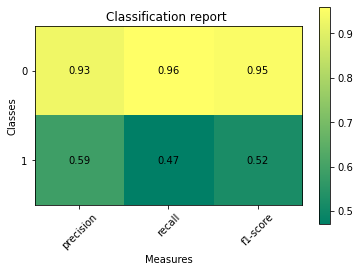

In [16]:
knn_plot_cr = """  precision    recall  f1-score   support

           0       0.93      0.96      0.95      7303
           1       0.59      0.47      0.52       932

    accuracy                           0.90      8235
   macro avg       0.76      0.71      0.73      8235
weighted avg       0.89      0.90      0.90      8235"""

plot_classification_report(knn_plot_cr)

### ROC Curve

No Skill: ROC AUC=0.500
RF: ROC AUC=0.868


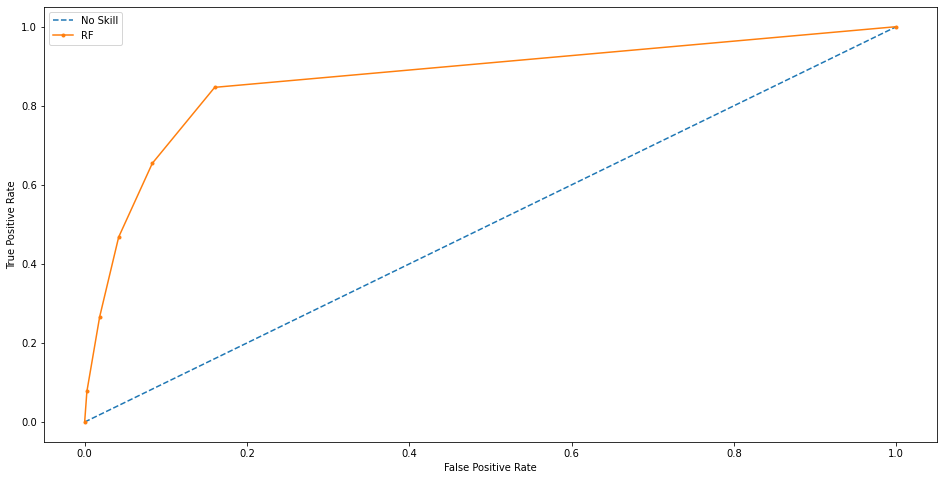

In [17]:
ROC_function(knn, X_test, y_test)

In [111]:
knn_f1 = f1_score(y_test, y_pred, average=None)
knn_f1

array([0.94579616, 0.520908  ])

* #### With Standard Scaling of data

In [77]:
knn_ss = make_pipeline(standardizer, KNeighborsClassifier())
knn_ss.fit(X_train, y_train)
knn_ss.score(X_test, y_test)

0.8970248937462052

In [78]:
y_pred_ss = knn_ss.predict(X_test)

In [79]:
knn_ss_acc = round(metrics.accuracy_score(y_test, y_pred_ss)*100, 2)
knn_ss_bacc = round(metrics.balanced_accuracy_score(y_test, y_pred_ss)*100, 2)

print(f"Accuracy: {knn_ss_acc}%")
print(f"Balanced Accuracy: {knn_ss_bacc}%")


Accuracy: 89.7%
Balanced Accuracy: 64.62%


In [80]:
knn_ss_classification_report = classification_report(y_test, y_pred_ss)
print(knn_ss_classification_report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7303
           1       0.58      0.32      0.41       932

    accuracy                           0.90      8235
   macro avg       0.75      0.65      0.68      8235
weighted avg       0.88      0.90      0.88      8235



In [81]:
knn_ss_cm = confusion_matrix(y_test, y_pred_ss)
print(knn_ss_cm)

[[7087  216]
 [ 632  300]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

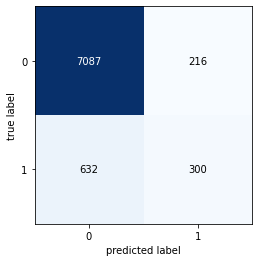

In [82]:
plot_confusion_matrix(knn_ss_cm)

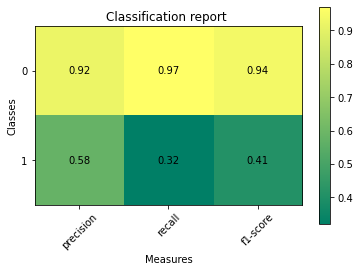

In [85]:
knn_plot_ss_cr = """  precision    recall  f1-score   support

           0       0.92      0.97      0.94      7303
           1       0.58      0.32      0.41       932

    accuracy                           0.90      8235
   macro avg       0.75      0.65      0.68      8235
weighted avg       0.88      0.90      0.88      8235"""

plot_classification_report(knn_plot_ss_cr)

No Skill: ROC AUC=0.500
RF: ROC AUC=0.816


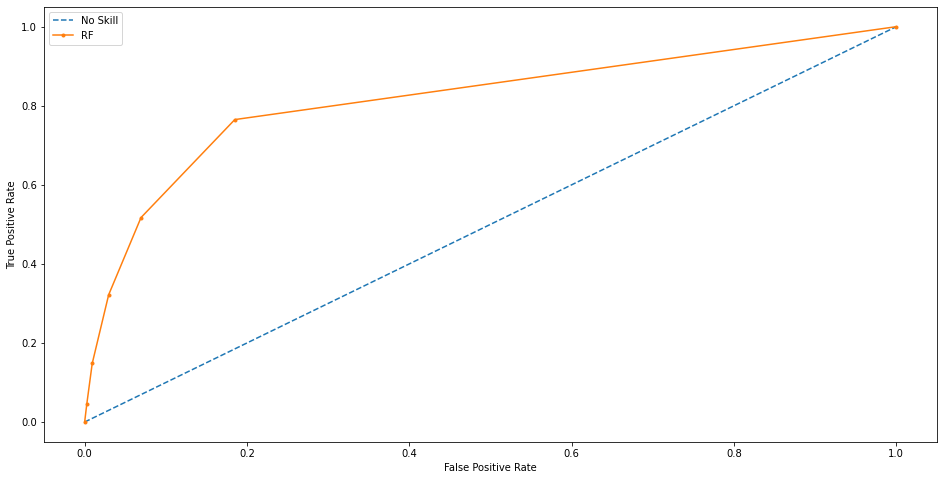

In [84]:
ROC_function(knn_ss, X_test, y_test)

In [110]:
knn_ss_f1 = f1_score(y_test, y_pred_ss, average=None)
knn_ss_f1

array([0.94354946, 0.41436464])

### k-fold cross validation

In [28]:
knn_kfold = KNeighborsClassifier(n_neighbors = 5)
knn_kfold.fit(X_train, y_train)

# 5-fold
scores = cross_val_score(knn_kfold, X_test, y_test, cv=5, scoring='accuracy')

print(scores)

[0.89981785 0.89738919 0.90771099 0.90771099 0.89678203]


In [29]:
print(scores.mean())

0.9018822100789314


### Simulating for k

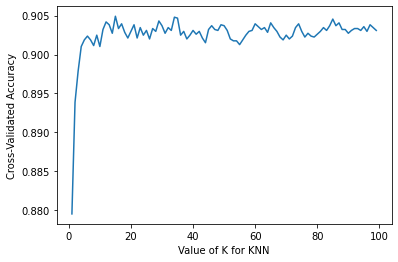

In [30]:
k_range = range(1, 100)
k_scores = []

# calculate different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    scores = cross_val_score(knn, X_test, y_test, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
    
# plot to see clearly
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()



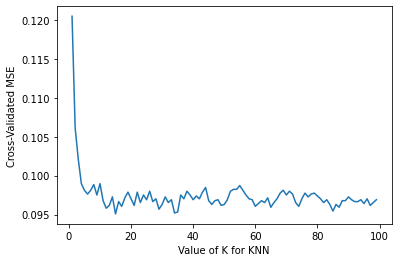

In [31]:
k_range = range(1, 100)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    loss = abs(cross_val_score(knn, X_test, y_test, cv=5, scoring='neg_mean_squared_error'))
    k_scores.append(loss.mean())
    
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE')
plt.show()

### KNN on SMOTE Data

* #### Without Standard Scaling Data

In [33]:
knn_smote = KNeighborsClassifier(n_neighbors = 15)
knn_smote.fit(X_SMOTE, y_SMOTE)

KNeighborsClassifier(n_neighbors=15)

In [34]:
y_smote_pred = knn_smote.predict(X_test)

In [35]:
knn_smote_acc = round(metrics.accuracy_score(y_test, y_smote_pred)*100, 2)
knn_smote_bacc = round(metrics.balanced_accuracy_score(y_test, y_smote_pred)*100, 2)

print(f"Accuracy: {knn_smote_acc}%")
print(f"Balanced Accuracy: {knn_smote_bacc}%")

Accuracy: 83.67%
Balanced Accuracy: 85.03%


In [36]:
knn_smote_classification_report = classification_report(y_test, y_smote_pred)
print(knn_smote_classification_report)

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      7303
           1       0.40      0.87      0.55       932

    accuracy                           0.84      8235
   macro avg       0.69      0.85      0.72      8235
weighted avg       0.91      0.84      0.86      8235



In [37]:
knn_smote_cm = confusion_matrix(y_test, y_smote_pred)
print(knn_smote_cm)

[[6081 1222]
 [ 123  809]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

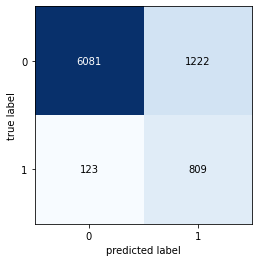

In [38]:
plot_confusion_matrix(knn_smote_cm)

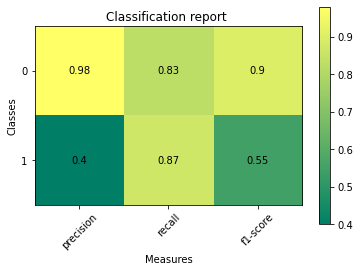

In [39]:
knn__smote_plot_cr = """  precision    recall  f1-score   support

           0       0.98      0.83      0.90      7303
           1       0.40      0.87      0.55       932

    accuracy                           0.84      8235
   macro avg       0.69      0.85      0.72      8235
weighted avg       0.91      0.84      0.86      8235"""

plot_classification_report(knn__smote_plot_cr)

### ROC Curve

No Skill: ROC AUC=0.500
RF: ROC AUC=0.913


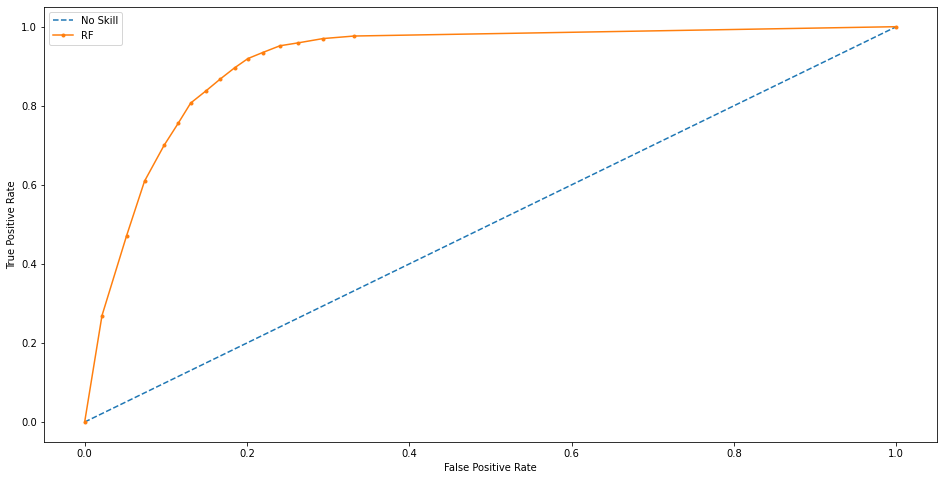

In [40]:
ROC_function(knn_smote, X_test, y_test)

In [109]:
knn_smote_f1 = f1_score(y_test, y_smote_pred, average=None)
knn_smote_f1

array([0.900422  , 0.54606817])

* #### With Standard Scaling Data


In [86]:
knn_smote_ss = make_pipeline(standardizer, KNeighborsClassifier())
knn_smote_ss.fit(X_SMOTE, y_SMOTE)
knn_smote_ss.score(X_test, y_test)

0.8931390406800243

In [87]:
y_smote_ss_pred = knn_smote_ss.predict(X_test)

In [88]:
knn_smote_ss_acc = round(metrics.accuracy_score(y_test, y_smote_ss_pred)*100, 2)
knn_smote_ss_bacc = round(metrics.balanced_accuracy_score(y_test, y_smote_ss_pred)*100, 2)

print(f"Accuracy: {knn_smote_ss_acc}%")
print(f"Balanced Accuracy: {knn_smote_ss_bacc}%")

Accuracy: 89.31%
Balanced Accuracy: 65.61%


In [89]:
knn_smote_ss_cr = classification_report(y_test, y_smote_ss_pred)
print(knn_smote_ss_cr)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      7303
           1       0.54      0.35      0.43       932

    accuracy                           0.89      8235
   macro avg       0.73      0.66      0.68      8235
weighted avg       0.88      0.89      0.88      8235



In [90]:
knn_smote_ss_cm = confusion_matrix(y_test, y_smote_ss_pred)
print(knn_smote_ss_cm)

[[7029  274]
 [ 606  326]]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

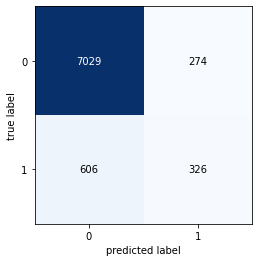

In [91]:
plot_confusion_matrix(knn_smote_ss_cm)

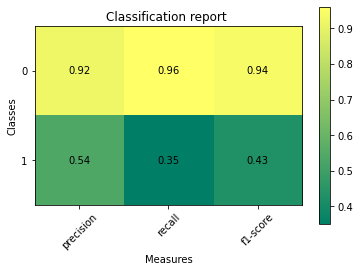

In [93]:
knn__smote_ss_plot_cr = """  precision    recall  f1-score   support

           0       0.92      0.96      0.94      7303
           1       0.54      0.35      0.43       932

    accuracy                           0.89      8235
   macro avg       0.73      0.66      0.68      8235
weighted avg       0.88      0.89      0.88      8235"""

plot_classification_report(knn__smote_ss_plot_cr)

No Skill: ROC AUC=0.500
RF: ROC AUC=0.782


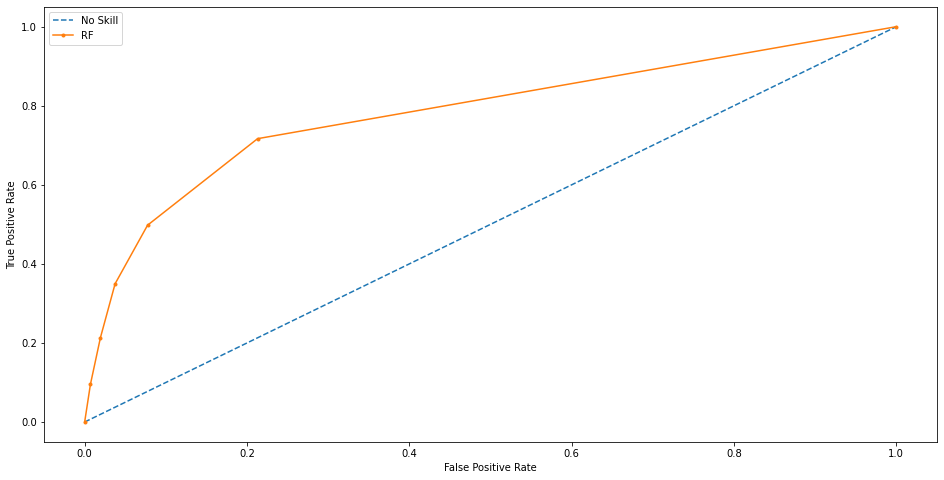

In [92]:
ROC_function(knn_smote_ss, X_test, y_test)

In [108]:
knn_smote_ss_f1 = f1_score(y_test, y_smote_ss_pred, average=None)
knn_smote_ss_f1

array([0.94108984, 0.42558747])

***

## Final Results:

In [112]:
models = ['KNN: Imbalanced Data', 'KNN: Imbalanced Scaled Data', 'KNN: SMOTE data', 'KNN: SMOTE Scaled Data']
accs = [knn_acc, knn_ss_acc, knn_smote_acc, knn_smote_ss_acc]
balanced_accs = [knn_bacc, knn_ss_bacc, knn_smote_bacc, knn_smote_ss_bacc]
f1_scores = [knn_f1[1], knn_ss_f1[1], knn_smote_f1[1], knn_smote_ss_f1[1]]

modelsResult = {'Models': models, 'Accuracies': accs, 'Balanced Accuracies': balanced_accs, 'f1-Scores': f1_scores}

modelsDf = pd.DataFrame(modelsResult)
modelsDf

,Models,Accuracies,Balanced Accuracies,f1-Scores
0,KNN: Imbalanced Data,90.26,71.30,0.520908
1,KNN: Imbalanced Scaled Data,89.70,64.62,0.414365
2,KNN: SMOTE data,83.67,85.03,0.546068
3,KNN: SMOTE Scaled Data,89.31,65.61,0.425587


### Models Performance Comparison

Text(0.5, 1.0, 'Accuracies vs Balanced Accuracies')

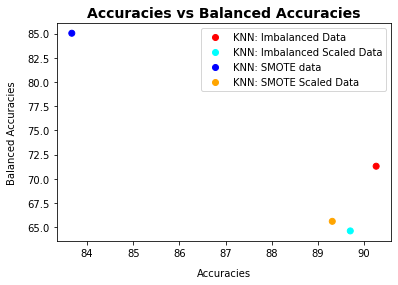

In [103]:
x = modelsDf['Accuracies']
y = modelsDf['Balanced Accuracies']
classes = list(modelsDf['Models'])
values = [0, 1, 2, 3]
colours = ListedColormap(['red','brown','cyan', 'green', 'blue', 'orange'])
scatter = plt.scatter(x, y,c=values, cmap=colours)
plt.xlabel('Accuracies', labelpad=10)
plt.ylabel('Balanced Accuracies', labelpad=10)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('Accuracies vs Balanced Accuracies', fontweight='bold', size=14)

Text(0.5, 1.0, 'f1-Scores vs Balanced Accuracies')

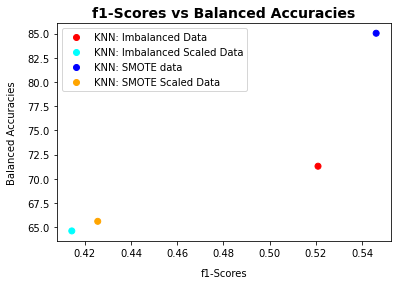

In [113]:
x = modelsDf['f1-Scores']
y = modelsDf['Balanced Accuracies']
classes = list(modelsDf['Models'])
values = [0, 1, 2, 3]
colours = ListedColormap(['red','brown','cyan', 'green', 'blue', 'orange'])
scatter = plt.scatter(x, y,c=values, cmap=colours)
plt.xlabel('f1-Scores', labelpad=10)
plt.ylabel('Balanced Accuracies', labelpad=10)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('f1-Scores vs Balanced Accuracies', fontweight='bold', size=14)

## References

* https://www.dataquest.io/blog/k-nearest-neighbors-in-python/
* https://towardsdatascience.com/implementing-k-nearest-neighbors-with-scikit-learn-9e4858e231ea
* https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
* https://medium.com/@svanillasun/how-to-deal-with-cross-validation-based-on-knn-algorithm-compute-auc-based-on-naive-bayes-ff4b8284cff4
* https://medium.com/datadriveninvestor/increase-10-accuracy-with-re-scaling-features-in-k-nearest-neighbors-python-code-677d28032a45
